In [1]:
from keras.layers import Dense,Flatten, Dropout, BatchNormalization, UpSampling2D, Reshape,Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image
import scipy.ndimage
from PIL import Image as PILImage


Using TensorFlow backend.


In [ ]:
x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

In [4]:
zlatan_4 = PILImage.open('/input/zlatan_4.jpeg')

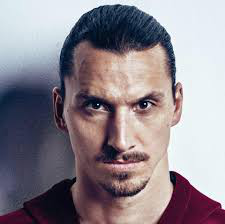

In [8]:
zlatan_4

In [11]:
def get_mnist_batch(batch_size=256, change_colors=True):
    
    # Select random batch (WxHxC)
    idx = np.random.choice(x_train.shape[0], batch_size)
    batch_raw = x_train[idx, :, :, 0].reshape((batch_size, 28, 28, 1))
    
    # Resize (this is optional but results in a training set of larger images)
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (2.3, 2.3, 1), order=1) for image in batch_raw])
    
    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)
    
    # Convert the MNIST images to binary
    batch_binary = (batch_rgb > 0.5)
    
    # Create a new placeholder variable for our batch
    batch = np.zeros((batch_size, 64, 64, 3))
    
    for i in range(batch_size):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 64)
        y_c = np.random.randint(0, lena.size[1] - 64)
        image = lena.crop((x_c, y_c, x_c + 64, y_c + 64))
        # Conver the image to float between 0 and 1
        image = np.asarray(image) / 255.0

        if change_colors:
            # Change color distribution
            for j in range(3):
                image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]
        
        batch[i] = image

    return batch

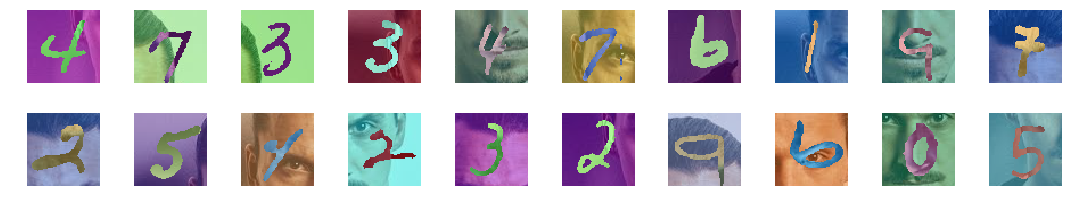

In [12]:
count = 20
examples = get_mnist_batch(count)

plt.figure(figsize=(15,3))
for i in range(count):
    plt.subplot(2, count // 2, i+1)
    plt.imshow(examples[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()


In [13]:
def discriminator():
    
    net = Sequential()
    input_shape = (64, 64, 3)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

In [14]:
D = discriminator()

In [15]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(8*8*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    net.add(Reshape((8,8,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(Activation('relu'))
    
    net.add(Conv2D(3, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

In [16]:
G = generator()

In [17]:
opt_discriminator = RMSprop(lr = 0.0002, clipvalue = 1.0, decay = 6e-8)
model_discriminator = Sequential()
   
model_discriminator.add(D)
model_discriminator.compile(loss = 'binary_crossentropy', optimizer = opt_discriminator, metrics = ['accuracy'])

In [18]:
opt_adversarial = Adam(lr = 0.0001, clipvalue = 1.0, decay = 3e-8)
model_adversarial = Sequential()
model_adversarial.add(G)

for layer in D.layers:
    layer.trainable = False

model_adversarial.add(D)
model_adversarial.compile(loss='binary_crossentropy', optimizer = opt_adversarial, metrics = ['accuracy'])

In [22]:
model_adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         3209283   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4314753   
Total params: 7,524,036
Trainable params: 3,175,811
Non-trainable params: 4,348,225
_________________________________________________________________


In [23]:
batch_size = 128

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

In [12]:
# dis_accuracy = given correct labels for natural+fake --> Identify Fake --> High acc --> D is good
# adv_accuracy = given all labels = 1 for natural + fake --> Identify Fake --> High acc --> D is being fooled

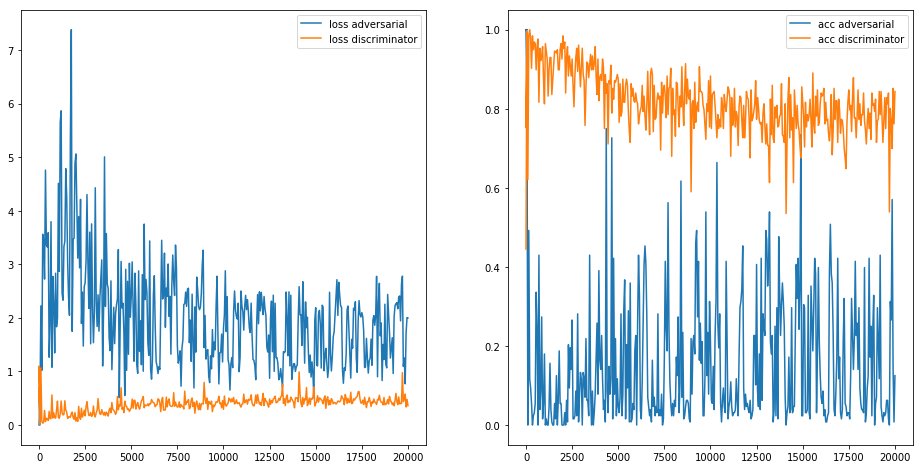

In [27]:
for i in range(0, 20001):
    
    images_train = get_mnist_batch(batch_size)
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = G.predict(noise)
    
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    y = np.ones([batch_size, 1])
    # Train the generator for a number of times
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
        
    if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)
        fig,(ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        #ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()
        
    
    if (i < 1000 and i%50 == 0) or (i % 100 == 0):
        images = G.predict(vis_noise)
        
        # Map back to original range
        #images = (images + 1 ) * 0.5
        
        plt.figure(figsize=(10,10))
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [64,64,3])
            plt.imshow(image)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(r'/output/{}.png'.format(i))
        plt.close('all')

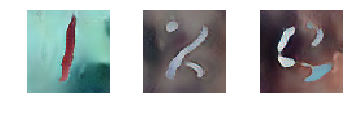

In [30]:
a = np.random.uniform(-1.0, 1.0, size=[1, 100])
b = np.random.uniform(-1.0, 1.0, size=[1, 100])

image_a = np.reshape(G.predict(a)[0],  [64, 64, 3])
image_b = np.reshape(G.predict(b)[0],  [64, 64, 3])
image_sum = np.reshape(G.predict(b - a)[0],  [64, 64, 3])

plt.figure(figsize=(5,4))

plt.subplot(1,3,1)
plt.imshow(image_a)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_b)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_sum)
plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
G.save('G_weights.h5')
model_discriminator.save('D_weights.h5')
model_adversarial.save('DG_weights.h5')